In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [43]:
%%bash
# Install ViZDoom deps from
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

sudo apt update

apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip ffmpeg

# Boost libraries
apt-get install libboost-all-dev

# Lua binding dependencies
apt-get install liblua5.1-dev

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,598 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 1,855 kB in 1s (1,757 kB/s)
Reading package lists...
Building dependency tree...
Reading state information...
175 packages can be upgraded. Run 'apt list --upgradable' to see



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [44]:
# install python libraries
# thanks toinsson
!pip install faster-fifo==1.4.2
!pip install vizdoom

  Using cached faster_fifo-1.4.2-cp311-cp311-linux_x86_64.whl
  Attempting uninstall: faster-fifo
    Found existing installation: faster-fifo 1.5.2
    Uninstalling faster-fifo-1.5.2:
      Successfully uninstalled faster-fifo-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
signal-slot-mp 1.0.5 requires faster-fifo<2.0,>=1.4.4, but you have faster-fifo 1.4.2 which is incompatible.


In [45]:
!pip install sample-factory==2.0.3

  Using cached faster_fifo-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.9 kB)
Using cached faster_fifo-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (423 kB)
  Attempting uninstall: faster-fifo
    Found existing installation: faster-fifo 1.4.2
    Uninstalling faster-fifo-1.4.2:
      Successfully uninstalled faster-fifo-1.4.2


In [46]:
import functools

from sample_factory.algo.utils.context import global_model_factory
from sample_factory.cfg.arguments import parse_full_cfg, parse_sf_args
from sample_factory.envs.env_utils import register_env
from sample_factory.train import run_rl

from sf_examples.vizdoom.doom.doom_model import make_vizdoom_encoder
from sf_examples.vizdoom.doom.doom_params import add_doom_env_args, doom_override_defaults
from sf_examples.vizdoom.doom.doom_utils import DOOM_ENVS, make_doom_env_from_spec


# Registers all the ViZDoom environments
def register_vizdoom_envs():
    for env_spec in DOOM_ENVS:
        make_env_func = functools.partial(make_doom_env_from_spec, env_spec)
        register_env(env_spec.name, make_env_func)

# Sample Factory allows the registration of a custom Neural Network architecture
# See https://github.com/alex-petrenko/sample-factory/blob/master/sf_examples/vizdoom/doom/doom_model.py for more details
def register_vizdoom_models():
    global_model_factory().register_encoder_factory(make_vizdoom_encoder)


def register_vizdoom_components():
    register_vizdoom_envs()
    register_vizdoom_models()

# parse the command line args and create a config
def parse_vizdoom_cfg(argv=None, evaluation=False):
    parser, _ = parse_sf_args(argv=argv, evaluation=evaluation)
    # parameters specific to Doom envs
    add_doom_env_args(parser)
    # override Doom default values for algo parameters
    doom_override_defaults(parser)
    # second parsing pass yields the final configuration
    final_cfg = parse_full_cfg(parser, argv)
    return final_cfg

In [72]:
## Start the training, this should take around  minutes
register_vizdoom_components()

env = "doom_health_gathering_supreme"
cfg = parse_vizdoom_cfg(argv=[f"--env={env}",
                              # Argumentos clave modificados
                              "--num_workers=20", # REDUCIDO: Solo necesitamos un worker para renderizar
                              "--train_for_env_steps=10000000", # REDUCIDO: 50k pasos es un buen test rápido
                              "--train_for_seconds=67200", # Mantenido, pero los pasos lo limitarán primero

                              
                            
                              # Argumentos originales del modelo (se mantienen)
                              "--restart_behavior=restart",
                              "--num_envs_per_worker=12",
                              "--batch_size=2048",
                              "--recurrence=32",
                              "--exploration_loss_coeff=0.001",
                              "--exploration_loss=symmetric_kl",
                              "--ppo_clip_value=0.2",
                              "--max_grad_norm=0.0",
                              "--obs_scale=255.0",
                              "--decorrelate_experience_max_seconds=1",
                              "--heartbeat_interval=10",
                              "--heartbeat_reporting_interval=300",
                              "--benchmark=false",
                              "--use_rnn=true",
                              "--rnn_type=lstm",
                              "--nonlinearity=relu"
                              ])

status = run_rl(cfg)

[2025-12-03 05:37:26,595][00047] Environment doom_basic already registered, overwriting...
[2025-12-03 05:37:26,597][00047] Environment doom_two_colors_easy already registered, overwriting...
[2025-12-03 05:37:26,598][00047] Environment doom_two_colors_hard already registered, overwriting...
[2025-12-03 05:37:26,599][00047] Environment doom_dm already registered, overwriting...
[2025-12-03 05:37:26,600][00047] Environment doom_dwango5 already registered, overwriting...
[2025-12-03 05:37:26,600][00047] Environment doom_my_way_home_flat_actions already registered, overwriting...
[2025-12-03 05:37:26,602][00047] Environment doom_defend_the_center_flat_actions already registered, overwriting...
[2025-12-03 05:37:26,602][00047] Environment doom_my_way_home already registered, overwriting...
[2025-12-03 05:37:26,603][00047] Environment doom_deadly_corridor already registered, overwriting...
[2025-12-03 05:37:26,604][00047] Environment doom_defend_the_center already registered, overwriting...

In [73]:
from sample_factory.enjoy import enjoy
register_vizdoom_components()
env = "doom_health_gathering_supreme"
cfg = parse_vizdoom_cfg(argv=[f"--env={env}", "--num_workers=1", "--save_video", "--no_render", "--max_num_episodes=10"], evaluation=True)
status = enjoy(cfg)

[2025-12-03 05:53:36,625][00047] Environment doom_basic already registered, overwriting...
[2025-12-03 05:53:36,626][00047] Environment doom_two_colors_easy already registered, overwriting...
[2025-12-03 05:53:36,627][00047] Environment doom_two_colors_hard already registered, overwriting...
[2025-12-03 05:53:36,628][00047] Environment doom_dm already registered, overwriting...
[2025-12-03 05:53:36,629][00047] Environment doom_dwango5 already registered, overwriting...
[2025-12-03 05:53:36,630][00047] Environment doom_my_way_home_flat_actions already registered, overwriting...
[2025-12-03 05:53:36,630][00047] Environment doom_defend_the_center_flat_actions already registered, overwriting...
[2025-12-03 05:53:36,632][00047] Environment doom_my_way_home already registered, overwriting...
[2025-12-03 05:53:36,632][00047] Environment doom_deadly_corridor already registered, overwriting...
[2025-12-03 05:53:36,633][00047] Environment doom_defend_the_center already registered, overwriting...

In [74]:
from base64 import b64encode
from IPython.display import HTML

mp4 = open('/kaggle/working/train_dir/default_experiment/replay.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=640 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [75]:

# 1. Desinstalar la versión conflictiva y instalar la compatible (3.20.x es la más estable para esto)
!pip uninstall -y protobuf
!pip install protobuf==3.20.3

Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensor

--- INICIO DEL DIAGNÓSTICO ---
Directorio de trabajo actual: /kaggle/working

1. Buscando archivos .tfevents en '.'...
   -> Encontrado: events.out.tfevents.1764738855.eae6ca3a899d (Tamaño: 247779 bytes)
   -> Encontrado: events.out.tfevents.1764728788.eae6ca3a899d (Tamaño: 174431 bytes)
   -> Encontrado: events.out.tfevents.1764729048.eae6ca3a899d (Tamaño: 155491 bytes)
   -> Encontrado: events.out.tfevents.1764735853.eae6ca3a899d (Tamaño: 258650 bytes)
   -> Encontrado: events.out.tfevents.1764740246.eae6ca3a899d (Tamaño: 802499 bytes)

2. Intentando leer: ./train_dir/default_experiment/.summary/0/events.out.tfevents.1764740246.eae6ca3a899d
   -> Lectura exitosa. Etiquetas encontradas: ['stats/master_process_memory_mb', 'perf/_fps', 'perf/_sample_throughput', 'stats/memory_policy_worker', 'stats/gpu_mem_policy_worker', 'stats/gpu_cache_policy_worker', 'stats/avg_request_count', 'train/lr', 'train/actual_lr', 'train/obs_running_mean', 'train/obs_running_std', 'train/returns_running_me

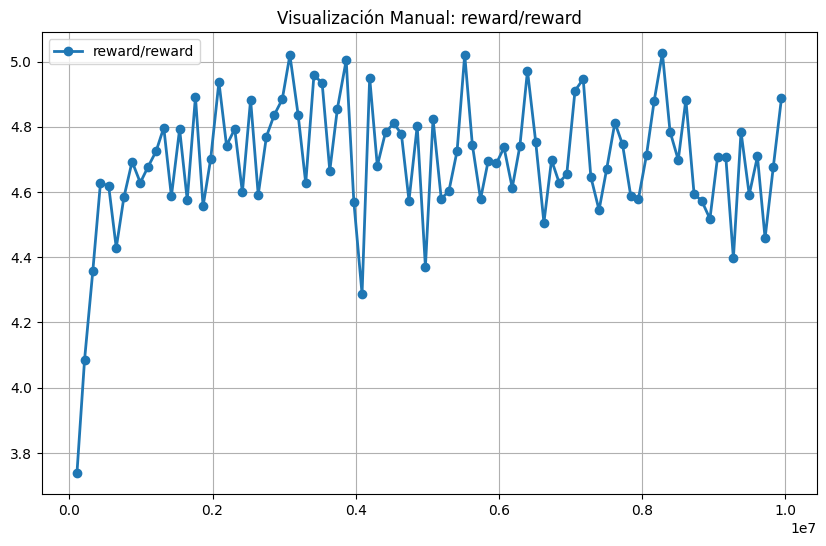


--- GRÁFICA GENERADA (Mira arriba) ---


In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def diagnostico_extremo(root_dir="."):
    print("--- INICIO DEL DIAGNÓSTICO ---")
    print(f"Directorio de trabajo actual: {os.getcwd()}")
    
    # 1. Buscar archivo tfevents en CUALQUIER lugar (recursivo)
    print(f"\n1. Buscando archivos .tfevents en '{root_dir}'...")
    target_file = None
    
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if "tfevents" in file:
                full_path = os.path.join(root, file)
                size = os.path.getsize(full_path)
                print(f"   -> Encontrado: {file} (Tamaño: {size} bytes)")
                if size > 0:
                    target_file = full_path
    
    if not target_file:
        print("\n[ERROR CRÍTICO] No se encontraron archivos de logs válidos.")
        print("Listado de carpetas en el directorio actual:")
        print(os.listdir(root_dir))
        return

    print(f"\n2. Intentando leer: {target_file}")
    
    # 2. Intentar leer datos
    try:
        # size_guidance=0 obliga a leer todo
        ea = EventAccumulator(target_file, size_guidance={'scalars': 0})
        ea.Reload()
        tags = ea.Tags()['scalars']
        print(f"   -> Lectura exitosa. Etiquetas encontradas: {tags}")
    except Exception as e:
        print(f"\n[ERROR CRÍTICO] Falló la lectura de Tensorboard: {e}")
        return

    # 3. Extraer datos
    y_vals = []
    x_vals = []
    
    # Intentamos varias etiquetas comunes
    possible_tags = ['reward/reward', 'reward_mean', 'train/reward', 'reward']
    chosen_tag = None
    
    for tag in possible_tags:
        if tag in tags:
            chosen_tag = tag
            break
            
    if not chosen_tag and len(tags) > 0:
        chosen_tag = tags[0] # Si no coincide ninguna, agarra la primera que haya
        
    if chosen_tag:
        print(f"\n3. Graficando etiqueta: {chosen_tag}")
        events = ea.Scalars(chosen_tag)
        x_vals = [e.step for e in events]
        y_vals = [e.value for e in events]
        print(f"   -> Datos extraídos: {len(y_vals)} puntos.")
        print(f"   -> Valores X: {x_vals}")
        print(f"   -> Valores Y: {y_vals}")
    else:
        print("\n[ERROR] El archivo existe pero no tiene etiquetas escalares.")
        return

    # 4. Graficar (incluso si es un solo punto)
    if len(y_vals) > 0:
        plt.figure(figsize=(10, 6))
        # Usamos 'o-' para que si hay un solo punto, se dibuje el punto gordo
        plt.plot(x_vals, y_vals, 'o-', linewidth=2, label=chosen_tag)
        plt.title(f"Visualización Manual: {chosen_tag}")
        plt.grid(True)
        plt.legend()
        plt.show()
        print("\n--- GRÁFICA GENERADA (Mira arriba) ---")
    else:
        print("\n[AVISO] Se encontraron etiquetas pero la lista de datos está vacía.")

# Ejecutamos buscando desde la carpeta actual
diagnostico_extremo(".")

In [77]:
import vizdoom, os

root = os.path.dirname(vizdoom.__file__)
print("VizDoom instalado en:", root)

print("\nArchivos dentro del paquete:")
print(os.listdir(root))

print("\nEscenarios disponibles:")
print(os.listdir(os.path.join(root, "scenarios")))


VizDoom instalado en: /usr/local/lib/python3.11/dist-packages/vizdoom

Archivos dentro del paquete:
['vizdoom', '__init__.py', '__pycache__', 'vizdoom.cpython-311-x86_64-linux-gnu.so', 'bots.cfg', 'gym_wrapper', 'freedoom2.wad', 'scenarios', 'gymnasium_wrapper', 'vizdoom.pk3']

Escenarios disponibles:
['deathmatch.cfg', 'cig_with_unknown.wad', 'deadly_corridor.wad', 'defend_the_center.wad', 'predict_position.wad', 'take_cover.cfg', 'defend_the_line.wad', 'health_gathering.cfg', 'take_cover.wad', 'deathmatch.wad', 'multi_duel.cfg', 'my_way_home.cfg', 'defend_the_line.cfg', 'simpler_basic.cfg', 'learning.cfg', 'cig.cfg', 'basic.wad', 'multi_duel.wad', 'health_gathering.wad', 'rocket_basic.cfg', 'README.md', 'simpler_basic.wad', 'health_gathering_supreme.cfg', 'multi_deathmatch.wad', 'my_way_home.wad', 'multi.cfg', 'rocket_basic.wad', 'oblige.cfg', 'predict_position.cfg', 'defend_the_center.cfg', 'basic.cfg', 'health_gathering_supreme.wad', 'deadly_corridor.cfg', 'cig.wad']


In [78]:
from vizdoom import DoomGame
import random

# --- Crear entorno correctamente ---

def make_random_agent_env():
    game = DoomGame()
    game.load_config("/usr/local/lib/python3.11/dist-packages/vizdoom/scenarios/health_gathering_supreme.cfg")
    game.set_window_visible(False)
    game.init()
    return game


# Crear un nuevo game para el agente aleatorio
game = make_random_agent_env()


# --- Ejecutar agente aleatorio ---
def run_random_agent(env, n_episodes=5):
    rewards = []
    for _ in range(n_episodes):
        env.new_episode()
        total_reward = 0

        while not env.is_episode_finished():
            action = [random.choice([0, 1]) for _ in range(env.get_available_buttons_size())]
            env.make_action(action)
            total_reward += env.get_last_reward()

        rewards.append(total_reward)

    return rewards

# Ejecutar agente aleatorio
rewards_random_agent = run_random_agent(game, n_episodes=5)
print("Recompensas agente aleatorio:", rewards_random_agent)




Recompensas agente aleatorio: [284.0, 348.0, 316.0, 348.0, 444.0]


In [79]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

def cargar_recompensas_entrenado(root_dir="."):
    print("Buscando logs del agente entrenado...")

    target_file = None

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if "tfevents" in file:
                full_path = os.path.join(root, file)
                if os.path.getsize(full_path) > 0:
                    target_file = full_path

    if target_file is None:
        raise FileNotFoundError("No se encontró ningún archivo tfevents válido.")

    ea = EventAccumulator(target_file, size_guidance={'scalars': 0})
    ea.Reload()
    tags = ea.Tags()['scalars']

    # Etiquetas más comunes
    possible_tags = ['reward/reward', 'reward_mean', 'train/reward', 'reward']
    chosen_tag = None

    for tag in possible_tags:
        if tag in tags:
            chosen_tag = tag
            break
    
    if chosen_tag is None:
        chosen_tag = tags[0]  # elegir la primera disponible

    events = ea.Scalars(chosen_tag)
    rewards = [e.value for e in events]

    print(f"Recompensas cargadas del agente entrenado: {len(rewards)} valores.")
    return rewards


In [80]:
import matplotlib.pyplot as plt

def comparar_agentes(rewards_trained, rewards_random):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards_trained, label="Agente Entrenado", linewidth=2)
    plt.title("Agente Entrenado")
    plt.xlabel("Episodios (o pasos en el caso del entrenado)")
    plt.ylabel("Recompensa")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(rewards_random, label="Agente Aleatorio", linewidth=2)
    plt.title("Agente Aleatorio")
    plt.xlabel("Episodios (o pasos en el caso del entrenado)")
    plt.ylabel("Recompensa")
    plt.grid(True)
    plt.legend()
    plt.show()


In [81]:
import numpy as np

def resumen_estadistico(rewards_trained, rewards_random):
    print("=== RESUMEN ESTADÍSTICO ===\n")

    print("Agente Entrenado:")
    print(f"  → Recompensa promedio: {np.mean(rewards_trained):.2f}")
    print(f"  → Recompensa máxima:   {np.max(rewards_trained):.2f}")
    print(f"  → Recompensa mínima:   {np.min(rewards_trained):.2f}")
    print(f"  → Varianza:             {np.var(rewards_trained):.2f}")

    print("\nAgente Aleatorio:")
    print(f"  → Recompensa promedio: {np.mean(rewards_random):.2f}")
    print(f"  → Recompensa máxima:   {np.max(rewards_random):.2f}")
    print(f"  → Recompensa mínima:   {np.min(rewards_random):.2f}")
    print(f"  → Varianza:             {np.var(rewards_random):.2f}")


Buscando logs del agente entrenado...
Recompensas cargadas del agente entrenado: 90 valores.


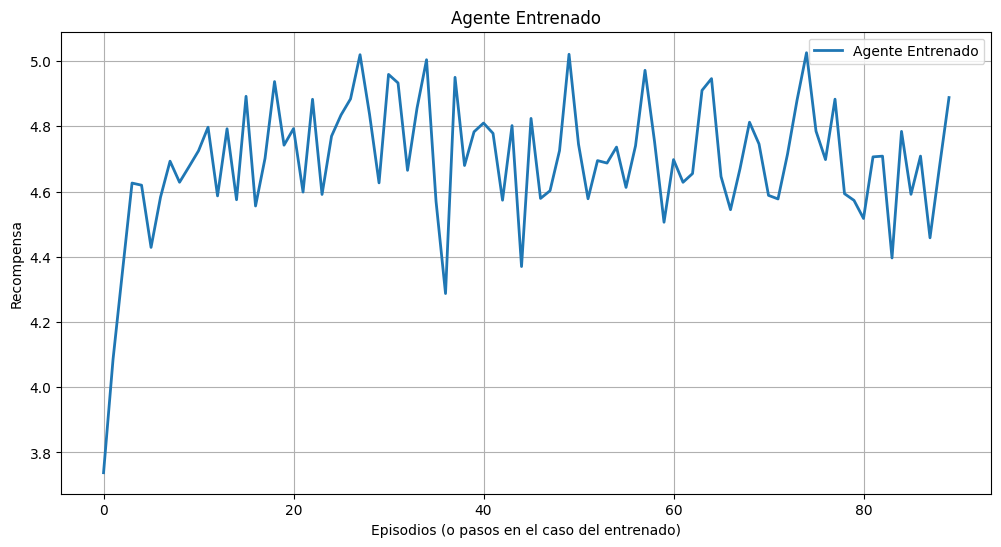

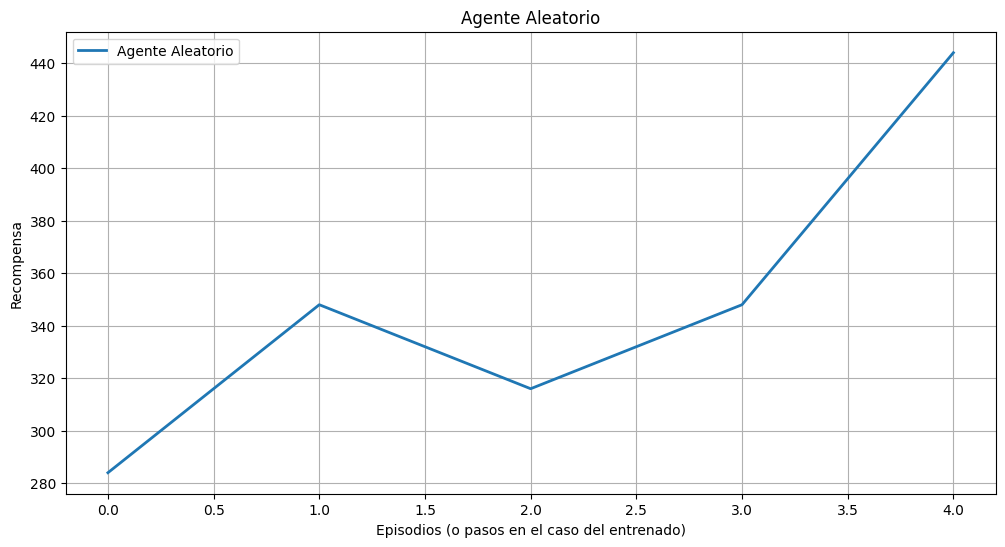

=== RESUMEN ESTADÍSTICO ===

Agente Entrenado:
  → Recompensa promedio: 4.69
  → Recompensa máxima:   5.03
  → Recompensa mínima:   3.74
  → Varianza:             0.04

Agente Aleatorio:
  → Recompensa promedio: 348.00
  → Recompensa máxima:   444.00
  → Recompensa mínima:   284.00
  → Varianza:             2867.20


In [82]:
# 1. Cargar recompensas del entrenado
rewards_trained = cargar_recompensas_entrenado("./train_dir")

# 2. Graficar comparación
comparar_agentes(rewards_trained, rewards_random_agent)

# 3. Crear resumen estadístico
resumen_estadistico(rewards_trained, rewards_random_agent)
